In [ ]:
import subprocess
import time

stocks_process = subprocess.Popen(
    ['dolt', 'sql-server', '--port', '3307'],
    cwd='../data/raw/stocks'
)

options_process = subprocess.Popen(
    ['dolt', 'sql-server', '--port', '3308'],
    cwd='../data/raw/options'
)

time.sleep(3)

print("Dolt SQL servers for stocks and options have been started.")


Dolt SQL servers for stocks and options have been started.


In [34]:
#!pip install mysql-connector-python
import mysql.connector

In [35]:
# Connect to the Stocks Dolt DB running on port 3307
conn_stocks = mysql.connector.connect(
    host='127.0.0.1',
    port=3307,
    user='root',
    password='',
    database='stocks'
)

cursor_stocks = conn_stocks.cursor()

cursor_stocks.execute("SHOW TABLES;")
stocks_tables = cursor_stocks.fetchall()
print("Stocks Database Tables:")
for table in stocks_tables:
    print(table[0])


Stocks Database Tables:
dividend
ohlcv
split
symbol


In [36]:
# Connect to the Options Dolt DB running on port 3308
conn_options = mysql.connector.connect(
    host='127.0.0.1',
    port=3308,
    user='root',
    password='',
    database='options'
)

cursor_options = conn_options.cursor()

cursor_options.execute("SHOW TABLES;")
options_tables = cursor_options.fetchall()
print("Options Database Tables:")
for table in options_tables:
    print(table[0])


Options Database Tables:
option_chain
volatility_history


In [37]:
import pandas as pd 

query = "SELECT * FROM ohlcv LIMIT 1000"
cursor_stocks.execute(query)
ohlcv = cursor_stocks.fetchall()
pd.DataFrame(ohlcv, columns=['date', 'symbol', 'open', 'high', 'low', 'close', 'volume'])

,date,symbol,open,high,low,close,volume
0,2011-01-03,A,41.56,42.14,41.41,41.88,3572300
1,2011-01-03,AACG,3.67,3.76,3.67,3.70,2400
2,2011-01-03,AADR,29.98,30.06,29.88,30.06,1581
3,2011-01-03,AAIC,24.22,24.74,24.22,24.60,37908
4,2011-01-03,AAME,2.06,2.06,2.06,2.06,1400
...,...,...,...,...,...,...,...
995,2011-01-03,EBMT,10.83,10.86,10.79,10.79,300
996,2011-01-03,EBR,13.91,14.04,13.88,14.00,878290
997,2011-01-03,EBR.B,16.72,16.89,16.70,16.86,315545
998,2011-01-03,EBS,23.63,23.92,23.55,23.78,357210


In [40]:
import pandas as pd

query = "SELECT * FROM option_chain LIMIT 1000"
cursor_options.execute(query)
option_chain = cursor_options.fetchall()

columns_option_chain = [
    'date', 'act_symbol', 'expiration', 'strike', 'call_put',
    'bid', 'ask', 'vol', 'delta', 'gamma', 'theta', 'vega', 'rho'
]

pd.DataFrame(option_chain, columns=columns_option_chain)

,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,theta,vega,rho
0,2019-02-09,A,2019-02-15,65.00,Call,10.50,11.25,0.2705,1.0000,0.0000,-0.0046,0.0000,0.0124
1,2019-02-09,A,2019-02-15,65.00,Put,0.00,0.03,0.3133,-0.0002,0.0002,-0.0002,0.0001,0.0000
2,2019-02-09,A,2019-02-15,67.50,Call,8.15,8.50,0.2705,0.9991,0.0010,-0.0053,0.0003,0.0129
3,2019-02-09,A,2019-02-15,67.50,Put,0.00,0.03,0.3133,-0.0034,0.0031,-0.0024,0.0011,0.0000
4,2019-02-09,A,2019-02-15,70.00,Call,5.70,6.00,0.2705,0.9845,0.0137,-0.0127,0.0041,0.0132
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2019-02-09,AGN,2019-02-22,123.00,Put,0.56,0.85,0.3403,-0.1505,0.0268,-0.0720,0.0622,-0.0073
996,2019-02-09,AGN,2019-02-22,127.00,Call,5.70,6.20,0.3028,0.7702,0.0480,-0.1106,0.0781,0.0248
997,2019-02-09,AGN,2019-02-22,127.00,Put,1.19,1.36,0.2967,-0.2662,0.0433,-0.0875,0.0859,-0.0126
998,2019-02-09,AGN,2019-02-22,129.00,Call,4.25,4.80,0.2994,0.6664,0.0550,-0.1224,0.0913,0.0239


In [82]:
import polars as pl

ohlcv_data = pl.read_csv("/Users/ryanfreidhoff/Desktop/DS 401/ds401-project/Data/Raw/stocks/csv/ohlcv.csv")

ohlcv_data = ohlcv_data.rename({"act_symbol": "Symbol"})

# Filter rows where Symbol is "AAPL"
aapl = ohlcv_data.filter(pl.col("Symbol") == "AAPL")

# Exponential Moving Average column calculated using the close
# smoothing is a constant, typically set to 2
# days is the period of days, typically set to 20
def calculate_ema(df, smoothing, days):
    close = df["close"]
    ema = [close[0]]  # Initialize EMA with the first close value

    for i in range(1, len(close)):
        prev_ema = ema[-1]
        current_close = close[i]
        if prev_ema is None:
            ema.append(current_close)
        else:
            ema.append(current_close * (smoothing)/(1+days) + prev_ema * (1 - (smoothing)/(1+days)))

    return pl.Series(ema)

# Add column for the Simple Moving Average (SMA) of Close using period 20
aapl = aapl.with_columns(
    [
        pl.col("close").rolling_mean(window_size=20).alias("SMA_20"),  # Add 20-period SMA
        calculate_ema(aapl, 2, 20).alias("EMA") # Add 20-period EMA
    ]
)

# Print the filtered DataFrame
print(aapl)

shape: (3_540, 9)
┌────────────┬────────┬────────┬────────┬───┬────────┬──────────┬──────────┬────────────┐
│ date       ┆ Symbol ┆ open   ┆ high   ┆ … ┆ close  ┆ volume   ┆ SMA_20   ┆ EMA        │
│ ---        ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---    ┆ ---      ┆ ---      ┆ ---        │
│ str        ┆ str    ┆ f64    ┆ f64    ┆   ┆ f64    ┆ i64      ┆ f64      ┆ f64        │
╞════════════╪════════╪════════╪════════╪═══╪════════╪══════════╪══════════╪════════════╡
│ 2011-01-03 ┆ AAPL   ┆ 325.9  ┆ 330.26 ┆ … ┆ 329.57 ┆ 15897201 ┆ null     ┆ 329.57     │
│ 2011-01-04 ┆ AAPL   ┆ 332.5  ┆ 332.5  ┆ … ┆ 331.29 ┆ 11048143 ┆ null     ┆ 329.73381  │
│ 2011-01-05 ┆ AAPL   ┆ 329.55 ┆ 334.34 ┆ … ┆ 334.0  ┆ 9125599  ┆ null     ┆ 330.140113 │
│ 2011-01-06 ┆ AAPL   ┆ 335.0  ┆ 335.25 ┆ … ┆ 333.73 ┆ 10729518 ┆ null     ┆ 330.482007 │
│ 2011-01-07 ┆ AAPL   ┆ 334.12 ┆ 336.35 ┆ … ┆ 336.12 ┆ 11140316 ┆ null     ┆ 331.018959 │
│ …          ┆ …      ┆ …      ┆ …      ┆ … ┆ …      ┆ …        ┆ …        ┆ …    

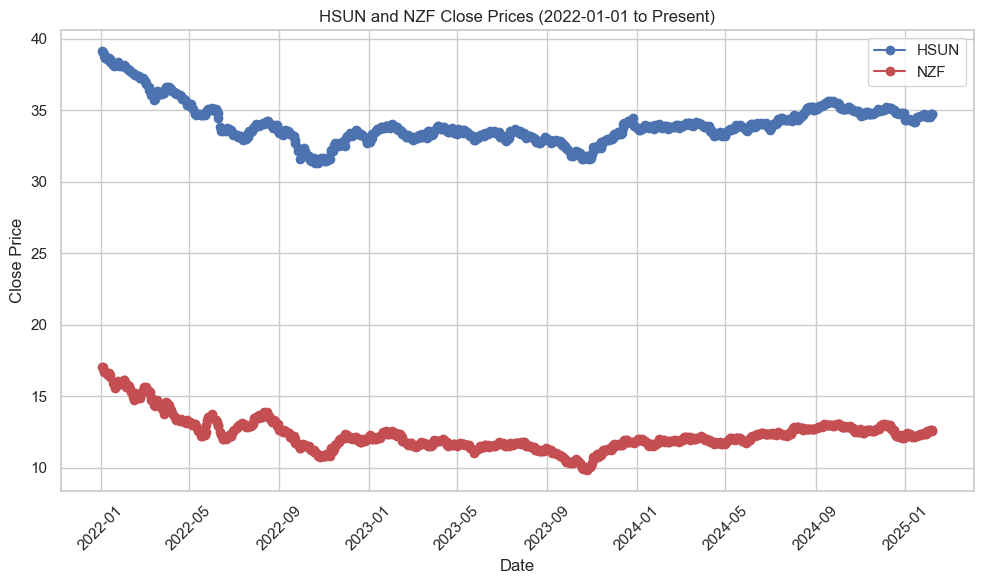

In [137]:
import matplotlib.pyplot as plt
import polars as pl
from datetime import datetime

# Filter rows where Symbol is "HSUN"
hsun = ohlcv_data.filter(pl.col("Symbol") == "HSUN")

# Convert 'date' to Date type if not already
if hsun["date"].dtype != pl.Date:
    hsun = hsun.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))

# Filter for dates from 2022-01-01 to the present using pl.lit()
hsun = hsun.filter(pl.col("date") >= pl.lit("2022-01-01").cast(pl.Date))

# Filter rows where Symbol is "NZF"
nzf = ohlcv_data.filter(pl.col("Symbol") == "NZF")

# Convert 'date' to Date type if not already
if nzf["date"].dtype != pl.Date:
    nzf = nzf.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))

# Filter for dates from 2022-01-01 to the present using pl.lit()
nzf = nzf.filter(pl.col("date") >= pl.lit("2022-01-01").cast(pl.Date))

# Plot the close price over time for both stocks on the same plot
plt.figure(figsize=(10, 6))
plt.plot(hsun["date"], hsun["close"], marker='o', linestyle='-', color='b', label='HSUN')
plt.plot(nzf["date"], nzf["close"], marker='o', linestyle='-', color='r', label='NZF')

# Adding labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("HSUN and NZF Close Prices (2022-01-01 to Present)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


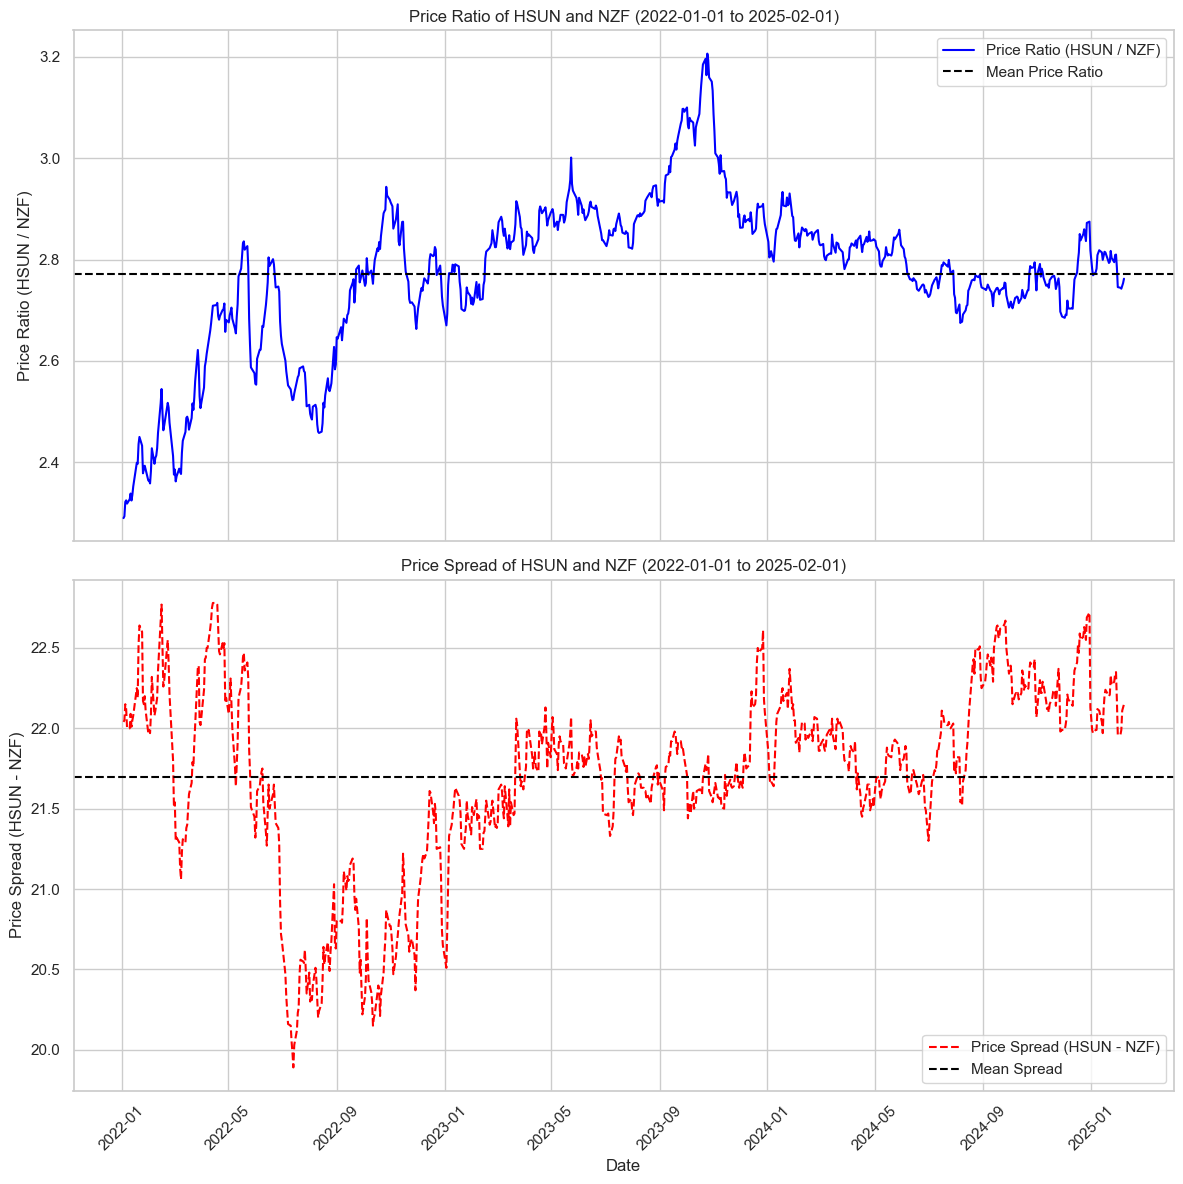

In [143]:
# Merge the two DataFrames on the 'date' column
merged_data = hsun.join(nzf, on="date", how="inner", suffix="_nzf")

# Calculate the ratio of close prices
merged_data = merged_data.with_columns(
    (pl.col("close") / pl.col("close_nzf")).alias("price_ratio")
)

# Calculate the spread as the difference between close prices
merged_data = merged_data.with_columns(
    (pl.col("close") - pl.col("close_nzf")).alias("spread")
)
spread = merged_data.with_columns(
    pl.col("spread")
)
ratio = merged_data.with_columns(
    pl.col("price_ratio")
)

# Create two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot the price ratio on the first subplot
ax1.plot(merged_data["date"], merged_data["price_ratio"], label='Price Ratio (HSUN / NZF)', color='blue')
ax1.axhline(merged_data["price_ratio"].mean(), color='black', linestyle='--', label='Mean Price Ratio')
ax1.set_title("Price Ratio of HSUN and NZF (2022-01-01 to 2025-02-01)")
ax1.set_ylabel("Price Ratio (HSUN / NZF)")
ax1.legend()
ax1.grid(True)

# Plot the spread on the second subplot
ax2.plot(merged_data["date"], merged_data["spread"], label='Price Spread (HSUN - NZF)', color='red', linestyle='--')
ax2.axhline(merged_data["spread"].mean(), color='black', linestyle='--', label='Mean Spread')
ax2.set_title("Price Spread of HSUN and NZF (2022-01-01 to 2025-02-01)")
ax2.set_xlabel("Date")
ax2.set_ylabel("Price Spread (HSUN - NZF)")
ax2.legend()
ax2.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

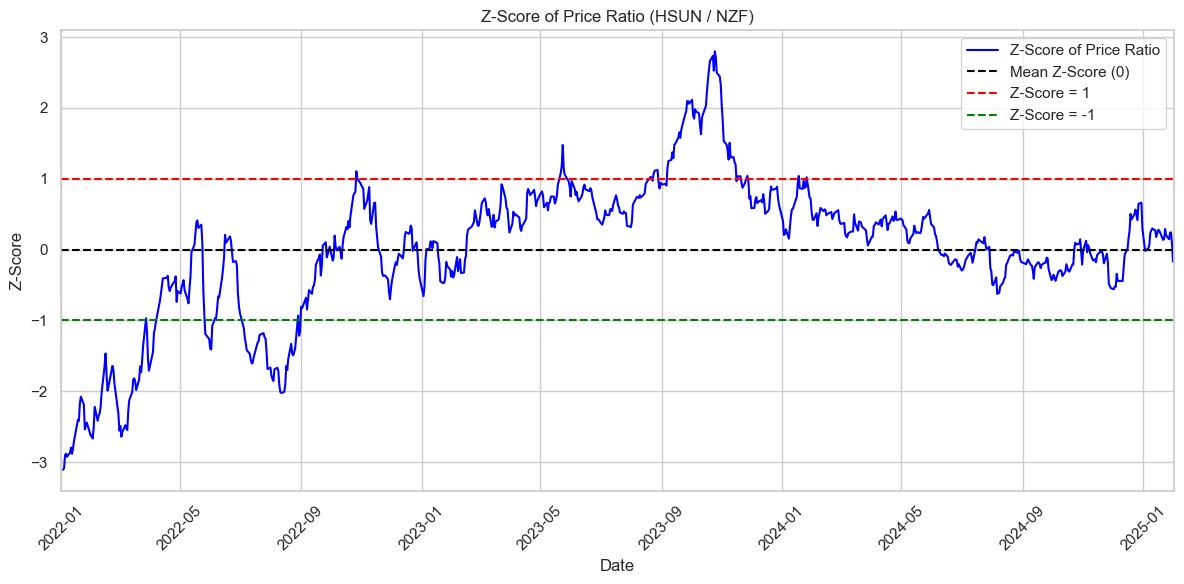

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the zscore function
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Ensure that 'ratio' is numerical before applying zscore
# Convert 'ratio' to a numpy array of floats
ratio_values = merged_data["price_ratio"].to_numpy()

# Calculate the zscore of the ratio
zscore_values = zscore(ratio_values)

# Plot the zscore of the price ratio
plt.figure(figsize=(12, 6))
plt.plot(merged_data["date"], zscore_values, label="Z-Score of Price Ratio", color="blue")
plt.axhline(0, color='black', linestyle='--', label='Mean Z-Score (0)')
plt.axhline(1.0, color='red', linestyle='--', label='Z-Score = 1')
plt.axhline(-1.0, color='green', linestyle='--', label='Z-Score = -1')
plt.xlim(datetime(2022, 1, 1), datetime(2025, 2, 1))
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.title("Z-Score of Price Ratio (HSUN / NZF)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


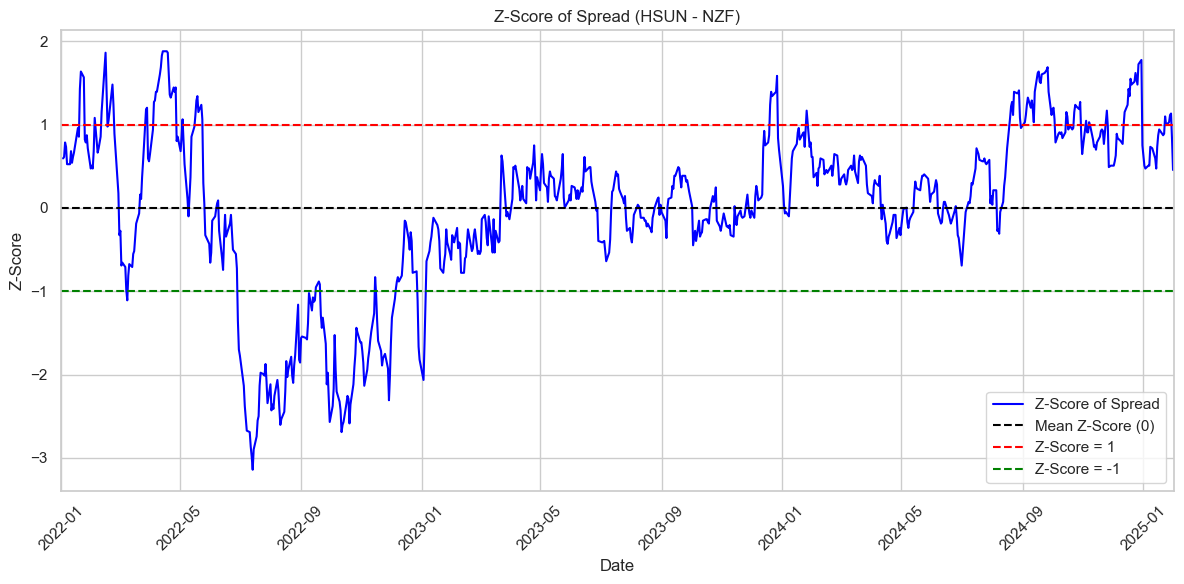

In [146]:
import numpy as np
import matplotlib.pyplot as plt

# Define the zscore function
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Ensure that 'ratio' is numerical before applying zscore
# Convert 'ratio' to a numpy array of floats
spread_values = merged_data["spread"].to_numpy()

# Calculate the zscore of the ratio
zscore_values = zscore(spread_values)

# Plot the zscore of the price ratio
plt.figure(figsize=(12, 6))
plt.plot(merged_data["date"], zscore_values, label="Z-Score of Spread", color="blue")
plt.axhline(0, color='black', linestyle='--', label='Mean Z-Score (0)')
plt.axhline(1.0, color='red', linestyle='--', label='Z-Score = 1')
plt.axhline(-1.0, color='green', linestyle='--', label='Z-Score = -1')
plt.xlim(datetime(2022, 1, 1), datetime(2025, 2, 1))
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.title("Z-Score of Spread (HSUN - NZF)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
import polars as pl
# Approximately 17.5s
options_data = pl.read_csv("/Users/ryanfreidhoff/Desktop/DS 401/ds401-project/Data/Raw/options/csv/option_chain.csv")

In [47]:
#date, act_symbol, expiration, strike, call_put, bid, ask, vol, delta, gamma, theta, vega, rho
print(options_data.head(5))

shape: (5, 13)
┌────────────┬────────────┬────────────┬────────┬───┬────────┬─────────┬────────┬────────┐
│ date       ┆ act_symbol ┆ expiration ┆ strike ┆ … ┆ gamma  ┆ theta   ┆ vega   ┆ rho    │
│ ---        ┆ ---        ┆ ---        ┆ ---    ┆   ┆ ---    ┆ ---     ┆ ---    ┆ ---    │
│ str        ┆ str        ┆ str        ┆ f64    ┆   ┆ f64    ┆ f64     ┆ f64    ┆ f64    │
╞════════════╪════════════╪════════════╪════════╪═══╪════════╪═════════╪════════╪════════╡
│ 2019-02-09 ┆ A          ┆ 2019-02-15 ┆ 65.0   ┆ … ┆ 0.0    ┆ -0.0046 ┆ 0.0    ┆ 0.0124 │
│ 2019-02-09 ┆ A          ┆ 2019-02-15 ┆ 65.0   ┆ … ┆ 0.0002 ┆ -0.0002 ┆ 0.0001 ┆ 0.0    │
│ 2019-02-09 ┆ A          ┆ 2019-02-15 ┆ 67.5   ┆ … ┆ 0.001  ┆ -0.0053 ┆ 0.0003 ┆ 0.0129 │
│ 2019-02-09 ┆ A          ┆ 2019-02-15 ┆ 67.5   ┆ … ┆ 0.0031 ┆ -0.0024 ┆ 0.0011 ┆ 0.0    │
│ 2019-02-09 ┆ A          ┆ 2019-02-15 ┆ 70.0   ┆ … ┆ 0.0137 ┆ -0.0127 ┆ 0.0041 ┆ 0.0132 │
└────────────┴────────────┴────────────┴────────┴───┴────────┴─────────┴───

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set_theme(style="whitegrid")
from statsmodels.tsa.stattools import coint, adfuller

## Stationarity Test
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

## Finds cointegration of different stocks
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = data[keys[i]]
            stock2 = data[keys[j]]
            result = coint(stock1, stock2)
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

## Function to plot the heatmap of p-values
def heatmap(pvalues, columns):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(pvalues, xticklabels=columns, yticklabels=columns, cmap='RdYlGn_r', mask=(pvalues >= 0.05))
    plt.title('Heatmap of Cointegration P-values')
    plt.show()

In [86]:
import random

# Convert the Date column to datetime64
ohlcv_data = ohlcv_data.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))

# Select random stock tickers
random_tickers = random.sample(ohlcv_data["Symbol"].to_list(), k=10)

# Filter the DataFrame to include only the selected tickers
ten_stocks = ohlcv_data.filter(pl.col("Symbol").is_in(random_tickers))
stock_count = ten_stocks["Symbol"].n_unique()

# Show the new DataFrame with data from the selected tickers
print(ten_stocks)
print(stock_count)

shape: (28_026, 7)
┌────────────┬────────┬───────┬───────┬───────┬───────┬─────────┐
│ date       ┆ Symbol ┆ open  ┆ high  ┆ low   ┆ close ┆ volume  │
│ ---        ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---     │
│ date       ┆ str    ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ i64     │
╞════════════╪════════╪═══════╪═══════╪═══════╪═══════╪═════════╡
│ 2011-01-03 ┆ CLMT   ┆ 21.47 ┆ 21.71 ┆ 21.3  ┆ 21.4  ┆ 91263   │
│ 2011-01-03 ┆ CPI    ┆ 25.4  ┆ 25.5  ┆ 25.4  ┆ 25.48 ┆ 1040    │
│ 2011-01-03 ┆ GLCN   ┆ 45.74 ┆ 45.83 ┆ 44.56 ┆ 45.81 ┆ 6595    │
│ 2011-01-03 ┆ NI     ┆ 17.72 ┆ 17.86 ┆ 17.71 ┆ 17.83 ┆ 2831799 │
│ 2011-01-03 ┆ SIF    ┆ 16.3  ┆ 16.6  ┆ 16.1  ┆ 16.1  ┆ 7047    │
│ …          ┆ …      ┆ …     ┆ …     ┆ …     ┆ …     ┆ …       │
│ 2025-02-07 ┆ CLMT   ┆ 16.52 ┆ 16.69 ┆ 16.1  ┆ 16.21 ┆ 734212  │
│ 2025-02-07 ┆ NI     ┆ 38.11 ┆ 38.5  ┆ 37.87 ┆ 37.93 ┆ 2989149 │
│ 2025-02-07 ┆ SIF    ┆ 3.84  ┆ 3.85  ┆ 3.75  ┆ 3.85  ┆ 3107    │
│ 2025-02-07 ┆ SPYG   ┆ 91.62 ┆ 92.0  ┆ 90.5  ┆ 90.69 ┆ 2

The below code chunk chooses 10 random stocks from our ohlcv data set. A heatmap of the p-values to test for cointegration is then created such that only the uppper diagonal with p-values less than 0.05 is shown.

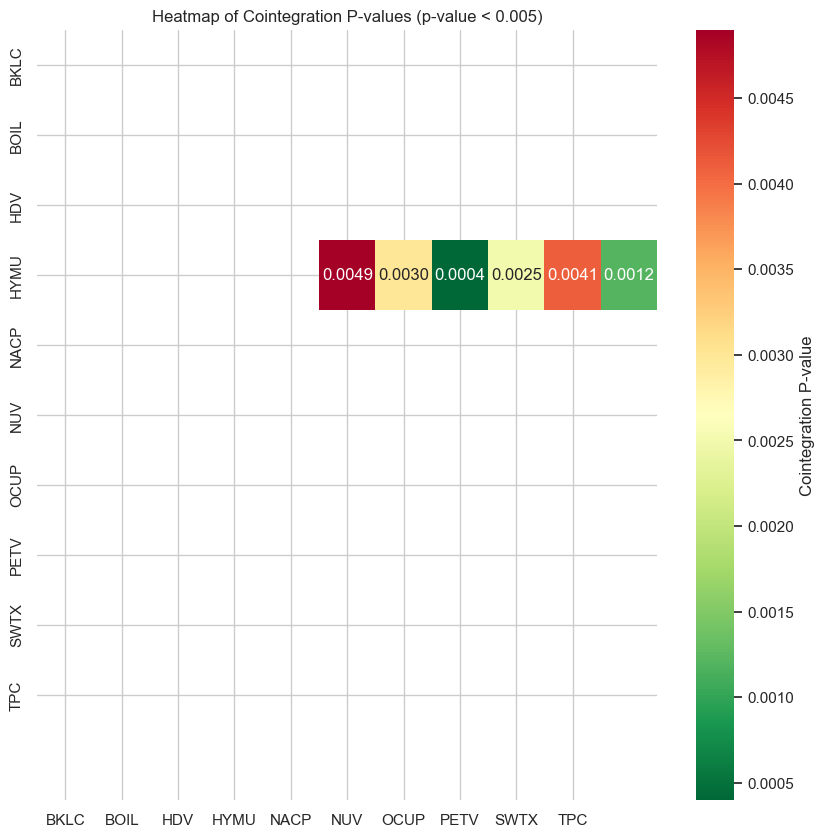

In [107]:
import polars as pl
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import coint
import pandas as pd

# Reading the CSV file with Polars
ohlcv_data = pl.read_csv("/Users/ryanfreidhoff/Desktop/DS 401/ds401-project/Data/Raw/stocks/csv/ohlcv.csv")

# Renaming the "act_symbol" column to "Symbol"
ohlcv_data = ohlcv_data.rename({"act_symbol": "Symbol"})

# Convert the Date column to datetime64
ohlcv_data = ohlcv_data.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))

# Filter the data for dates from 2023-01-01 to the present
ohlcv_past_two = ohlcv_data.filter(pl.col("date") >= pl.lit("2023-01-01").str.strptime(pl.Date))

# Select random stock tickers (10 random stocks)
random_tickers = random.sample(ohlcv_past_two["Symbol"].to_list(), k=10)

# Filter the DataFrame to include only the selected tickers
ten_stocks = ohlcv_past_two.filter(pl.col("Symbol").is_in(random_tickers))

# Pivot the DataFrame to have Date as the index and the stocks as columns (for time series analysis)
ten_stocks_pivot = ten_stocks.pivot(
    values="close",  # Assuming 'close' price is the column you're interested in
    index="date",    # 'date' column will be the index
    on="Symbol"      # Use 'Symbol' for the columns, as it's the identifier for the stocks
)

# Convert the Polars DataFrame to a Pandas DataFrame for cointegration analysis
ten_stocks_pandas = ten_stocks_pivot.to_pandas()

# Handle missing or infinite values by replacing them with NaN and then filling NaN values
ten_stocks_pandas.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace Inf with NaN
ten_stocks_pandas.ffill(inplace=True)  # Forward fill NaN values
ten_stocks_pandas.bfill(inplace=True)  # Backward fill NaN values

# Ensure that all stocks have data for the same dates by aligning the data
ten_stocks_pandas.dropna(axis=1, how='all', inplace=True)  # Drop columns with all NaNs

# Check if any stock columns are still empty after filling NaNs
if ten_stocks_pandas.isnull().all().any():
    print("Warning: Some stocks have no data after cleaning.")

# Define the function to find cointegrated pairs
def find_cointegrated_pairs(data, p_value_threshold):
    n = data.shape[1]
    keys = data.columns
    pairs = []

    # Perform the cointegration test for all pairs
    for i in range(n):
        for j in range(i + 1, n):
            stock1 = data[keys[i]]
            stock2 = data[keys[j]]
            result = coint(stock1, stock2)
            pvalue = result[1]
            
            # If p-value is lower than threshold, store the pair and its p-value
            if pvalue < p_value_threshold:
                pairs.append((keys[i], keys[j], pvalue))

    # Return as DataFrame
    return pd.DataFrame(pairs, columns=["Stock 1", "Stock 2", "P-value"])

# Function to plot the heatmap of p-values
def heatmap(pvalues, columns):
    # Create a figure and axis object for plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Format p-values to 4 decimal places for annotation
    formatted_pvalues = np.round(pvalues, 4)

    # Mask p-values greater than or equal to 0.005
    mask = formatted_pvalues >= 0.005
    
    # Set the masked p-values to NaN so they won't be shown on the heatmap
    formatted_pvalues[mask] = np.nan
    
    # Plot the heatmap
    sns.heatmap(
        formatted_pvalues, 
        xticklabels=columns, 
        yticklabels=columns, 
        cmap='RdYlGn_r', 
        mask=np.isnan(formatted_pvalues),  # Mask NaN values
        annot=True,                       # Add annotations to the heatmap
        fmt='.4f',                        # Format annotations to 4 decimal places
        cbar_kws={'label': 'Cointegration P-value'},  # Add color bar label
        ax=ax                             # Specify the axis
    )
    
    # Set title and show the plot
    plt.title('Heatmap of Cointegration P-values (p-value < 0.005)')
    plt.show()

In [125]:
import polars as pl
import random
import numpy as np

# Method to find the stock pairs
def pair_finder(p_value_threshold=0.005):
    # Filter the data for dates from 2023-01-01 to the present
    ohlcv_past_two = ohlcv_data.filter(pl.col("date") >= pl.lit("2023-01-01").str.strptime(pl.Date))

    # Select random stock tickers (10 random stocks)
    random_tickers = random.sample(ohlcv_past_two["Symbol"].to_list(), k=500)

    # Filter the DataFrame to include only the selected tickers
    ten_stocks = ohlcv_past_two.filter(pl.col("Symbol").is_in(random_tickers))

    # Pivot the DataFrame to have Date as the index and the stocks as columns (for time series analysis)
    ten_stocks_pivot = ten_stocks.pivot(
        values="close",  # Assuming 'close' price is the column you're interested in
        index="date",    # 'date' column will be the index
        on="Symbol"      # Use 'Symbol' for the columns, as it's the identifier for the stocks
    )

    # Convert the Polars DataFrame to a Pandas DataFrame for cointegration analysis
    ten_stocks_pandas = ten_stocks_pivot.to_pandas()

    # Handle missing or infinite values by replacing them with NaN and then filling NaN values
    ten_stocks_pandas.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace Inf with NaN
    ten_stocks_pandas.ffill(inplace=True)  # Forward fill NaN values
    ten_stocks_pandas.bfill(inplace=True)  # Backward fill NaN values

    # Ensure that all stocks have data for the same dates by aligning the data
    ten_stocks_pandas.dropna(axis=1, how='all', inplace=True)  # Drop columns with all NaNs

    # Check if any stock columns are still empty after filling NaNs
    if ten_stocks_pandas.isnull().all().any():
        print("Warning: Some stocks have no data after cleaning.")

    # Use the find_cointegrated_pairs function to get pairs below the p-value threshold
    cointegrated_pairs = find_cointegrated_pairs(ten_stocks_pandas, p_value_threshold)

    return cointegrated_pairs

In [126]:
p_value_threshold = 0.00005
pairs_df = pair_finder(p_value_threshold)
print(pairs_df)

    Stock 1 Stock 2       P-value
0      date    IVCA  7.263792e-11
1      ACWI    ITGR  1.282438e-05
2      AFGD    MGRD  9.335271e-06
3      ALGS    SCMB  2.039968e-05
4      ALGS    LINE  7.353210e-06
..      ...     ...           ...
295   BNIXW  BMTX.W  3.194859e-08
296   COOTW  BMTX.W  9.846649e-06
297   COOTW    LIAQ  3.198476e-05
298   COOTW    SMCL  5.159264e-06
299   NXLIW    LIAQ  6.295887e-11

[300 rows x 3 columns]


In [132]:
# Sort pairs_df by P-value in descending order
pairs_df_sorted = pairs_df.sort_values(by="P-value", ascending=True)

# Filter rows where the P-value is less than 0.000005
filtered_pairs_df = pairs_df_sorted[pairs_df_sorted["P-value"] < 0.000005]

# Combine 'Stock 1' and 'Stock 2' into a single series
stocks_combined = pd.concat([filtered_pairs_df['Stock 1'], filtered_pairs_df['Stock 2']])

# Count the occurrences of each unique stock
stock_counts = stocks_combined.value_counts()

# Create a new DataFrame with 'Stock' and 'Count' columns
stock_count_df = stock_counts.reset_index()
stock_count_df.columns = ['Stock', 'Count']

# Get the list of stocks that appear more than once (count > 1)
stocks_to_remove = stock_count_df[stock_count_df['Count'] > 1]['Stock'].tolist()

# Remove rows from filtered_pairs_df where 'Stock 1' or 'Stock 2' is in stocks_to_remove
filtered_pairs_df_no_duplicates = filtered_pairs_df[
    ~filtered_pairs_df['Stock 1'].isin(stocks_to_remove) &
    ~filtered_pairs_df['Stock 2'].isin(stocks_to_remove)
]

# Print the filtered DataFrame
print(filtered_pairs_df_no_duplicates)
#print(stock_count_df)
#print(filtered_pairs_df)

    Stock 1 Stock 2       P-value
256    ONCS     MWG  4.654791e-11
18     BOLT     USM  2.817457e-07
74     BRMK    KTCC  1.527346e-06
274    NBSD  PHGE.U  2.054720e-06
244    LPTH    TWLO  2.106159e-06
260   QRTEA    ULTA  2.762580e-06
238    HSUN     NZF  3.053508e-06
196     CSQ     EOI  3.325922e-06


Adding Calculated Columns

In [160]:
import polars as pl

ohlcv_data2 = pl.read_csv("/Users/ryanfreidhoff/Desktop/DS 401/ds401-project/Data/Raw/stocks/csv/ohlcv.csv")

ohlcv_data2 = ohlcv_data2.rename({"act_symbol": "Symbol"})

# Filter rows where Symbol is "AAPL"
aapl = ohlcv_data2.filter(pl.col("Symbol") == "AAPL")

# Exponential Moving Average column calculated using the close
# smoothing is a constant, typically set to 2
# days is the period of days, typically set to 20
def calculate_ema(df, smoothing, days):
    close = df["close"]
    ema = [close[0]]  # Initialize EMA with the first close value

    for i in range(1, len(close)):
        prev_ema = ema[-1]
        current_close = close[i]
        if prev_ema is None:
            ema.append(current_close)
        else:
            ema.append(current_close * (smoothing)/(1+days) + prev_ema * (1 - (smoothing)/(1+days)))

    return pl.Series(ema)

# Add column for the Simple Moving Average (SMA) of Close using period 20
aapl = aapl.with_columns(
    [
        pl.col("close").rolling_mean(window_size=20).alias("SMA"),  # Add 20-period SMA
        calculate_ema(aapl, 2, 20).alias("EMA") # Add 20-period EMA
    ]
)

# Print the filtered DataFrame
print(aapl)
#print(options_data)

shape: (3_540, 9)
┌────────────┬────────┬────────┬────────┬───┬────────┬──────────┬──────────┬────────────┐
│ date       ┆ Symbol ┆ open   ┆ high   ┆ … ┆ close  ┆ volume   ┆ SMA      ┆ EMA        │
│ ---        ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---    ┆ ---      ┆ ---      ┆ ---        │
│ str        ┆ str    ┆ f64    ┆ f64    ┆   ┆ f64    ┆ i64      ┆ f64      ┆ f64        │
╞════════════╪════════╪════════╪════════╪═══╪════════╪══════════╪══════════╪════════════╡
│ 2011-01-03 ┆ AAPL   ┆ 325.9  ┆ 330.26 ┆ … ┆ 329.57 ┆ 15897201 ┆ null     ┆ 329.57     │
│ 2011-01-04 ┆ AAPL   ┆ 332.5  ┆ 332.5  ┆ … ┆ 331.29 ┆ 11048143 ┆ null     ┆ 329.73381  │
│ 2011-01-05 ┆ AAPL   ┆ 329.55 ┆ 334.34 ┆ … ┆ 334.0  ┆ 9125599  ┆ null     ┆ 330.140113 │
│ 2011-01-06 ┆ AAPL   ┆ 335.0  ┆ 335.25 ┆ … ┆ 333.73 ┆ 10729518 ┆ null     ┆ 330.482007 │
│ 2011-01-07 ┆ AAPL   ┆ 334.12 ┆ 336.35 ┆ … ┆ 336.12 ┆ 11140316 ┆ null     ┆ 331.018959 │
│ …          ┆ …      ┆ …      ┆ …      ┆ … ┆ …      ┆ …        ┆ …        ┆ …    

In [161]:
import polars as pl

# Calculate the RSI using close
def calculate_rsi(df, window=14):
    delta = df["close"].diff().fill_null(0)  # Fill missing values with 0
    
    # Use Polars expressions for element-wise operations
    gain = pl.when(delta > 0).then(delta).otherwise(0)
    loss = pl.when(delta < 0).then(-delta).otherwise(0)
    
    # Calculate rolling means for gains and losses
    avg_gain = gain.rolling_mean(window)
    avg_loss = loss.rolling_mean(window)
    
    # Calculate the Relative Strength (RS) and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Add the RSI column to the DataFrame
aapl = aapl.with_columns([calculate_rsi(aapl).alias("RSI")])
print(aapl)

shape: (3_540, 10)
┌────────────┬────────┬────────┬────────┬───┬──────────┬──────────┬────────────┬───────────┐
│ date       ┆ Symbol ┆ open   ┆ high   ┆ … ┆ volume   ┆ SMA      ┆ EMA        ┆ RSI       │
│ ---        ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---      ┆ ---      ┆ ---        ┆ ---       │
│ str        ┆ str    ┆ f64    ┆ f64    ┆   ┆ i64      ┆ f64      ┆ f64        ┆ f64       │
╞════════════╪════════╪════════╪════════╪═══╪══════════╪══════════╪════════════╪═══════════╡
│ 2011-01-03 ┆ AAPL   ┆ 325.9  ┆ 330.26 ┆ … ┆ 15897201 ┆ null     ┆ 329.57     ┆ null      │
│ 2011-01-04 ┆ AAPL   ┆ 332.5  ┆ 332.5  ┆ … ┆ 11048143 ┆ null     ┆ 329.73381  ┆ null      │
│ 2011-01-05 ┆ AAPL   ┆ 329.55 ┆ 334.34 ┆ … ┆ 9125599  ┆ null     ┆ 330.140113 ┆ null      │
│ 2011-01-06 ┆ AAPL   ┆ 335.0  ┆ 335.25 ┆ … ┆ 10729518 ┆ null     ┆ 330.482007 ┆ null      │
│ 2011-01-07 ┆ AAPL   ┆ 334.12 ┆ 336.35 ┆ … ┆ 11140316 ┆ null     ┆ 331.018959 ┆ null      │
│ …          ┆ …      ┆ …      ┆ …      ┆ … ┆ …    

In [164]:
import polars as pl

# Function to calculate MACD
def calculate_macd(df, fast_window=12, slow_window=26, signal_window=9):
    # Calculate the smoothing factor for each EMA (2 / (window + 1))
    fast_smoothing = 2 / (fast_window + 1)
    slow_smoothing = 2 / (slow_window + 1)
    signal_smoothing = 2 / (signal_window + 1)

    # Calculate Fast EMA and Slow EMA using custom function
    fast_ema = calculate_ema(df, fast_smoothing, fast_window)
    slow_ema = calculate_ema(df, slow_smoothing, slow_window)
    
    # Calculate MACD Line (difference between Fast and Slow EMAs)
    macd_line = fast_ema - slow_ema
    
    # Calculate Signal Line (EMA of the MACD line)
    signal_line = calculate_ema(df, signal_smoothing, signal_window)
    
    # Calculate MACD Histogram (optional)
    macd_histogram = macd_line - signal_line
    
    return macd_line, signal_line, macd_histogram

# Add MACD, Signal Line, and Histogram to the DataFrame
aapl = aapl.with_columns([
    calculate_macd(aapl)[0].alias("MACD"),  # MACD Line
    calculate_macd(aapl)[1].alias("Signal Line"),  # Signal Line
    calculate_macd(aapl)[2].alias("MACD Histogram")  # MACD Histogram (optional)
])

print(aapl)

shape: (3_540, 13)
┌────────────┬────────┬────────┬────────┬───┬───────────┬───────────┬─────────────┬────────────────┐
│ date       ┆ Symbol ┆ open   ┆ high   ┆ … ┆ RSI       ┆ MACD      ┆ Signal Line ┆ MACD Histogram │
│ ---        ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---       ┆ ---       ┆ ---         ┆ ---            │
│ str        ┆ str    ┆ f64    ┆ f64    ┆   ┆ f64       ┆ f64       ┆ f64         ┆ f64            │
╞════════════╪════════╪════════╪════════╪═══╪═══════════╪═══════════╪═════════════╪════════════════╡
│ 2011-01-03 ┆ AAPL   ┆ 325.9  ┆ 330.26 ┆ … ┆ null      ┆ 0.0       ┆ 329.57      ┆ -329.57        │
│ 2011-01-04 ┆ AAPL   ┆ 332.5  ┆ 332.5  ┆ … ┆ null      ┆ 0.015636  ┆ 329.6044    ┆ -329.588764    │
│ 2011-01-05 ┆ AAPL   ┆ 329.55 ┆ 334.34 ┆ … ┆ null      ┆ 0.055681  ┆ 329.692312  ┆ -329.636631    │
│ 2011-01-06 ┆ AAPL   ┆ 335.0  ┆ 335.25 ┆ … ┆ null      ┆ 0.092686  ┆ 329.773066  ┆ -329.680379    │
│ 2011-01-07 ┆ AAPL   ┆ 334.12 ┆ 336.35 ┆ … ┆ null      ┆ 0.150878  ┆ 32

In [ ]:
## Look into predicting the Implied Volatility
## Historical Volatility can differ
## Use indicator vaiables and historical that we generate to map the implied volatility